# Pipelines, Hyperparameter tuning using Gridsearch and Model Evaluation Best practices

We will work on the publicaly available Brest cancer Dataset.
We construct several pipelines merging preprocessing and classifiers and we evaluate its accuracy on both training and testing datasets
We use cross validation techniques, learning curves and gridsearch to optimize our model and improve our classifier's accuracy
We conclude this notebook with resampling techniques

## Logistic Regression Pipeline
We construct a pipeline containing data preprocessing: StandardScaler, dimensionality reduction function: PCA and a classifier: LR
We evaluate our model's accuracy using k-fold cross validation

In [5]:
import pandas as pd 
import numpy as np 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
import pandas as pd 
import numpy as np 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, f1_score, recall_score
from sklearn.metrics import make_scorer
import ssl
from sklearn.utils import resample
ssl._create_default_https_context = ssl._create_unverified_context
#import data and first preprocessing stuff
df = pd.read_csv('https://archive.ics.uci.edu/ml/'
'machine-learning-databases'
'/breast-cancer-wisconsin/wdbc.data',header=None)
X=df.iloc[:,2:].values
Y=df.iloc[:,1].values
Y=np.where(Y=='M',1,0)

#pipeline
X_train,X_test,Y_train,Y_test= train_test_split(X,Y,test_size=0.2,stratify=Y,random_state=1)
lr_pipe=make_pipeline(StandardScaler(),PCA(n_components=2),LogisticRegression(random_state=1,solver='lbfgs',multi_class='auto',max_iter=2000))
lr_pipe.fit(X_train,Y_train)
y_pred=lr_pipe.predict(X_test)
print('the accuracy of our LR tested on the reduced Test data: %.3f ' % lr_pipe.score(X_test,Y_test))
#kfold cross validation to assess the effectiveness of a model
cr=cross_val_score(lr_pipe,X_train,Y_train,cv=10,n_jobs=1)
print("using stratified kfold we get the scores: %s" % cr)
print("our CV accuracy is: %.3f +/- %.3f " % (np.mean(cr),np.std(cr)))



the accuracy of our LR tested on the reduced Test data: 0.956 
using stratified kfold we get the scores: [0.93478261 0.93478261 0.95652174 0.95652174 0.93478261 0.95555556
 0.97777778 0.93333333 0.95555556 0.95555556]
our CV accuracy is: 0.950 +/- 0.014 


## Hyperparameter Tuning: Leraning Curves
We investigate the optimal training/testing set size as well as The optimal regularization parameter C and plot the curves

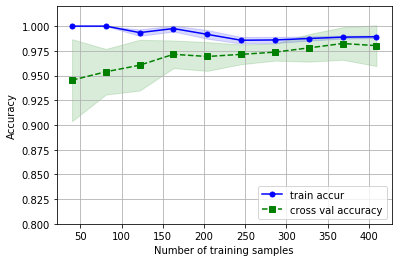

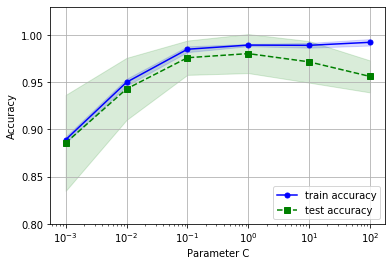

In [8]:
#Learning curve
lr_pipe1=make_pipeline(StandardScaler(),LogisticRegression(penalty='l2',random_state=1,solver='lbfgs',multi_class='auto',max_iter=2000))
train_sizes, train_scores, test_scores= learning_curve(lr_pipe1,X_train,Y_train,train_sizes=np.linspace(0.1,1.0,10),cv=10,n_jobs=1)
train_scores_mean=np.mean(train_scores,axis=1)
train_scores_std=np.std(train_scores,axis=1)
test_scores_mean=np.mean(test_scores,axis=1)
test_scores_std=np.std(test_scores,axis=1)
plt.plot(train_sizes,train_scores_mean,color='blue',marker='o',markersize=5,label='train accur')
plt.fill_between(train_sizes,train_scores_mean+train_scores_std,train_scores_mean-train_scores_std,color='blue',alpha=0.15)
plt.plot(train_sizes,test_scores_mean,marker='s',color='green',linestyle='--',label='cross val accuracy')
plt.fill_between(train_sizes,test_scores_mean+test_scores_std,test_scores_mean-test_scores_std,color='green',alpha=0.15)
plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.02])
#print(train_sizes[1])
plt.show()

param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]

train_scr,test_scr=validation_curve(lr_pipe1,X_train,Y_train,param_name='logisticregression__C',param_range=param_range,cv=10,n_jobs=1)
train_scr_m=np.mean(train_scr,axis=1)
train_scr_s=np.std(train_scr,axis=1)
test_scr_m=np.mean(test_scr,axis=1)
test_scr_s=np.std(test_scr,axis=1)

plt.plot(param_range,train_scr_m,marker='o',color='blue',markersize=5,label='train accuracy')
plt.fill_between(param_range,train_scr_m+train_scr_s,train_scr_m-train_scr_s,color='blue',alpha=0.15)
plt.plot(param_range,test_scr_m,marker='s',color='green',linestyle='--',label='test accuracy')
plt.fill_between(param_range,test_scr_m+test_scr_s,test_scr_m-test_scr_s,color='green',alpha=0.15)
plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.03])
plt.show()



## Finding optimal parameters using Gridsearch
In this subsection, we use gridsearch for hyperparameter tuning. We then fit our "optimal" classifier and evaluate the results

In [9]:

pipe_svc=make_pipeline(StandardScaler(),SVC(random_state=1,class_weight='balanced'))
parama_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
parama_grid=[{'svc__C':parama_range,'svc__kernel':['linear']},{'svc__C':parama_range,'svc__kernel':['rbf'],'svc__gamma':parama_range}]
gs=GridSearchCV(pipe_svc,param_grid=parama_grid,n_jobs=-1,cv=10,scoring='accuracy',iid='deprecated')
gs=gs.fit(X_train,Y_train)
print(gs.best_params_)
print(gs.best_score_)
clf=gs.best_estimator_
clf.fit(X_train,Y_train)
print("score of out best estimator applied to test data: %.4f" % clf.score(X_test,Y_test))
y_clf=clf.predict(X_test)
#nested cross validation 
gs1=GridSearchCV(pipe_svc,param_grid=parama_grid,scoring='accuracy',n_jobs=-1,cv=2)
cr1=cross_val_score(gs1,X_train,y=Y_train,scoring='accuracy',n_jobs=-1,cv=5)
print("acc score of our nested cross validation: %.3f +/- %.3f " % (np.mean(cr1),np.std(cr1)))

#lets construct a pipeline involving a decision tree and compare with our LR
#make the piple line
pipe_DT=make_pipeline(StandardScaler(),DecisionTreeClassifier(random_state=1))
#print(pipe_DT.get_params().keys())
dt_par_range=[1,2,3,4,5,6,7,None]
gs_DT=GridSearchCV(pipe_DT,param_grid={'decisiontreeclassifier__max_depth':dt_par_range},scoring='accuracy',n_jobs=-1,cv=2,iid='deprecated')
cr2=cross_val_score(gs_DT,X_train,y=Y_train,scoring='accuracy',cv=5,n_jobs=-1)
print("evaluating our nested cross validation for a dtree pipeline with different depths")
print("score dtree cv: %.3f +/- %.3f" % (np.mean(cr2),np.std(cr2)))



{'svc__C': 10.0, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}
0.9868131868131869
score of out best estimator applied to test data: 0.9737
acc score of our nested cross validation: 0.980 +/- 0.021 
evaluating our nested cross validation for a dtree pipeline with different depths
score dtree cv: 0.932 +/- 0.022


## Choosing the right evaluation criteria and resampling when needed
clf accuracy can sometimes be a misleading criteria.We need to consider other evaluation metrics such as recall, f1...
We can also use resampling in order to make sure our classifier is accurate

[[70  2]
 [ 2 40]]


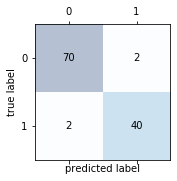

F1 score: 0.952
recall score: 0.952
prec score: 0.952
F1 score clf: 0.964
recall score clf: 0.952
prec score clf: 0.976
[357 212]
[357  40]
random guessing gives us the acc score 0.899
precision score when we resample: 0.929
precision score when we resample changing lab: 0.997
precision score when we resample using balanced class weigght: 0.990
shape after resampling:  357
random guessing gives us the acc score AFTER RESAMP 0.500


In [10]:
#confusion matrix
pipe_svc.fit(X_train,Y_train)
y_svc_pred=pipe_svc.predict(X_test)
confmat=confusion_matrix(Y_test,y_svc_pred)
print(confmat)

#plot confusion mat
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i,s=confmat[i, j],va='center', ha='center')
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()

print("F1 score: %.3f" % f1_score(Y_test,y_svc_pred))
print("recall score: %.3f" % recall_score(Y_test,y_svc_pred))
print("prec score: %.3f" % precision_score(Y_test,y_svc_pred))

#comapre with clf elli howa best fit (famma mochkla)
print("F1 score clf: %.3f" % f1_score(Y_test,y_clf))
print("recall score clf: %.3f" % recall_score(Y_test,y_clf))
print("prec score clf: %.3f" % precision_score(Y_test,y_clf))
'''
scorer= make_scorer(f1_score,pos_label=0)

gs4=GridSearchCV(pipe_svc,param_grid=parama_grid,scoring=scorer,n_jobs=-1,cv=10)
gs4=gs4.fit(X_train,Y_train)

print("best score gs4 %.3f: " % gs4.best_score_)
print("best param gs4 : " , gs4.best_params_)
'''
print(np.bincount(Y))
#create unbalanced set
X_sampled=np.vstack((X[Y==0],X[Y==1][:40]))
Y_sampled=np.hstack((Y[Y==0],Y[Y==1][:40]))
print(np.bincount(Y_sampled))

#show how misleading the model can be, random guessing seems good enough

print("random guessing gives us the acc score %.3f" % np.mean(np.zeros(Y_sampled.shape[0])==Y_sampled))

#we need to resample
y_pred_resam=pipe_svc.predict(X_sampled)
print("precision score when we resample: %.3f" % precision_score(Y_sampled,y_pred_resam))
print("precision score when we resample changing lab: %.3f" % precision_score(Y_sampled,y_pred_resam,pos_label=0))
#okay model still doing okay
print("precision score when we resample using balanced class weigght: %.3f" % pipe_svc.score(X_sampled,Y_sampled))

#resampling
X_resamp,Y_resamp= resample(X_sampled[Y_sampled==1],Y_sampled[Y_sampled==1],replace=True,n_samples=X_sampled[Y_sampled==0].shape[0],random_state=123)

print("shape after resampling: " ,X_resamp.shape[0])

#resampling done, see that random guessing is not working anymore
X_resamp=np.vstack((X_sampled[Y_sampled==0],X_resamp))
Y_resamp=np.hstack((Y_sampled[Y_sampled==0],Y_resamp))

print("random guessing gives us the acc score AFTER RESAMP %.3f" % np.mean(np.zeros(Y_resamp.shape[0])==Y_resamp))
#guessing no good no moe

